In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [2]:
plt.rcParams['axes.unicode_minus']=False
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=120,facecolor='w',frameon=True,figsize=(4,4)) 
%config InlineBackend.figure_format='retina'
%matplotlib inline

2023-12-19 13:39:53.295831: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 13:39:53.360750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 13:39:54.362649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.9.3 anndata==0.9.2 umap==0.5.5 numpy==1.23.5 scipy==1.8.1 pandas==1.5.0 scikit-learn==0.24.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.2


# Load data

In [3]:
adata=sc.read('../CCI/data/NSCLC_cc_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 97809 × 960
    obs: 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.CD298', 'Max.CD298', 'Mean.G', 'Max.G', 'Mean.Y', 'Max.Y', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'dualfiles', 'Slide_name', 'tissue', 'Run_name', 'ISH.concentration', 'Dash', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'log10totalcounts', 'background', 'remove_flagged_cells', 'patient', 'cell_type', 'niche', 'prop_tumor_in_100_neighbors', 'leiden', 'cell_comm', 'celltype'
    uns: 'SPACE', 'cell_comm_colors', 'cell_type_colors', 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'niche_colors', 'umap'
    obsm: 'X_umap', 'latent', 'spatial', 'spatial_viz'
    layers: 'counts'
    obsp: 'SPACE_connectivities', 'SPACE_distances'

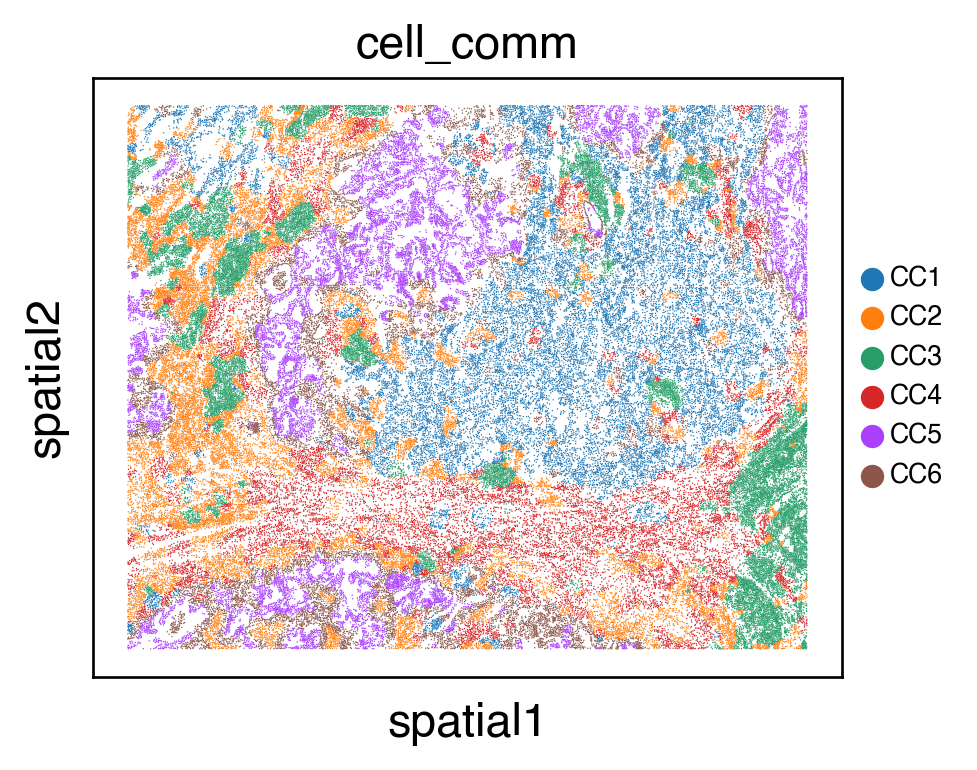

In [4]:
sc.pl.spatial(adata,color=['cell_comm'],spot_size=0.01,legend_fontsize=8)

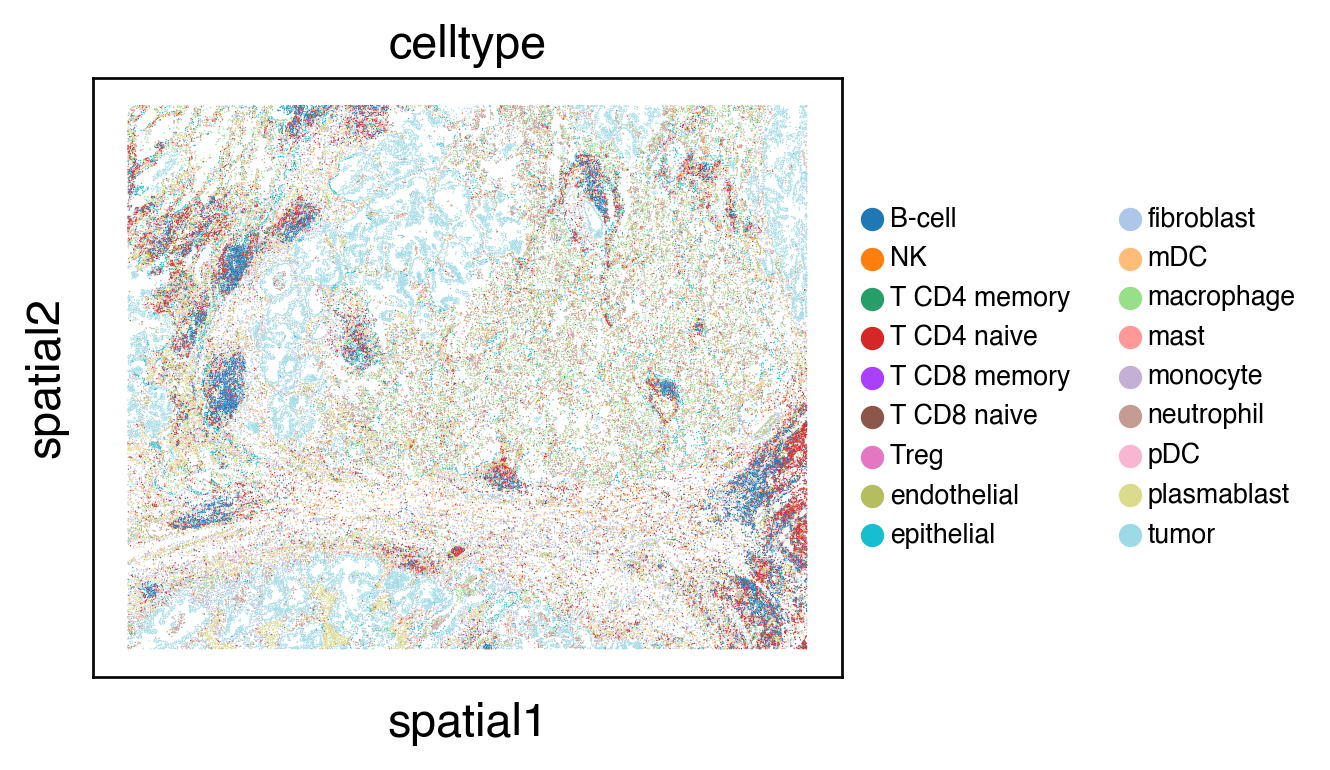

In [5]:
sc.pl.spatial(adata,color=['celltype'],spot_size=0.01,legend_fontsize=8)

In [6]:
for i in adata.obs.cell_comm.cat.categories:
    adata_=adata[(adata.obs.cell_comm.isin([i]))].copy()
    pd.DataFrame(adata_.transpose().X.toarray(),index=adata_.var.index, 
                 columns=['cell_'+i for i in adata_.obs.index]).to_csv('data/NSCLC_expr_{}.csv'.format(i))
    metadata=adata_.obs.copy()
    metadata.index=['cell_'+i for i in metadata.index]
    metadata.to_csv('data/NSCLC_metadata_{}.csv'.format(i))

In [7]:
def celltype_connectivity(adata,domain_key= 'Label',celltype_key = 'cluster'):
    import holoviews as hv
    import squidpy as sq
    import numpy as np
    from tqdm import tqdm
    import random
    random.seed(42)

    sq.gr.spatial_neighbors(adata, n_neighs = 20, coord_type = 'generic') 

    for label in adata.obs[domain_key].unique():
        # CCI
        adata_batch = adata[adata.obs[domain_key] == label].copy()  
        cell_types = adata_batch.obs[celltype_key].unique().tolist()
        sq.gr.interaction_matrix(adata_batch, cluster_key=celltype_key)
        CCI1=adata_batch.uns['{}_interactions'.format(celltype_key)].copy()
        CCI2=CCI1.T.copy()
        CCI=((CCI1+CCI2)/2).round()
        pairwise_connection=pd.DataFrame(CCI,
                                         index=adata_batch.obs[celltype_key].cat.categories,
                                         columns=adata_batch.obs[celltype_key].cat.categories)
        
        pairwise_connection[pairwise_connection<=0]=0
        
        # save data
        celltype_sum=pd.DataFrame(adata_batch.obs[celltype_key].value_counts())
        celltype_sub=celltype_sum[celltype_sum[celltype_key]>=10].copy()
        df=pairwise_connection.copy()
        min_x=df.min().min()
        max_x=df.max().max()
        for i in df.index:
            for j in df.columns:
                df.loc[i,j]=(df.loc[i,j]-min_x)/(max_x-min_x)
        df=df.loc[celltype_sum.index,celltype_sum.index].copy()
        df.to_csv('data/NSCLC_{}_prob.csv'.format(label))
        celltype_sub.to_csv('data/NSCLC_{}_size.csv'.format(label))
           
    return adata

In [8]:
celltype_key = "celltype"
domain_key = "cell_comm"

tmp = celltype_connectivity(adata=adata, domain_key=domain_key, celltype_key=celltype_key)

Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:02)
Adding `adata.uns['celltype_interactions']`
Adding `adata.uns['celltype_interactions']`
Adding `adata.uns['celltype_interactions']`
Adding `adata.uns['celltype_interactions']`
Adding `adata.uns['celltype_interactions']`
Adding `adata.uns['celltype_interactions']`
